In [1]:
from em.low_rank_expectation_maximization import LowRankExpectationMaximization
from evaluation.helpers import generate_LRGC, mask, get_mae, continuous2ordinal

from glrm.loss import QuadraticLoss, HingeLoss, OrdinalLoss
from glrm.reg import QuadraticReg
from glrm.glrm import GLRM
from glrm.convergence import Convergence
from glrm.util import pplot

import numpy as np
from numpy.random import randn, choice, seed
import math
import sys, os
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
import time

In [1]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [3]:
import pyglrm

/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [2]:
# Functions to calculate imputation error

class NormalisedRMSErr():
    def __call__(self, A, A_hat, indices=None): 
        #Normalize by the standard deviation of each column
        mask = np.tile(np.std(A, axis=0), (len(A), 1))
        A_diff = np.divide((A - A_hat), mask)
        if indices is not None:
            A_diff_temp = []
            for i, j in indices:
                A_diff_temp.append(A_diff[i, j])
            A_diff = np.array(A_diff_temp)
        return math.sqrt(np.mean(np.square(A_diff)))

class OrdErr():
    def __call__(self, A, A_hat, indices=None, all_thresh=False): 
        A_diff = np.abs(A - A_hat)
        if indices is not None:
            A_diff_temp = []
            for i, j in indices:
                A_diff_temp.append(A_diff[i, j])
            A_diff = np.array(A_diff_temp)
        if all_thresh is True:
            return np.sum(np.vectorize(cumu_sum)(A_diff)) / A_diff.size
        else:
            return np.sum(A_diff) / A_diff.size

class ClassErr():
    def __call__(self, A, A_hat, indices=None): 
        A_diff = A - A_hat
        if indices is not None:
            A_diff_temp = []
            for i, j in indices:
                A_diff_temp.append(A_diff[i, j])
            A_diff = np.array(A_diff_temp)
        return np.count_nonzero(A_diff) / A_diff.size
    
def cumu_sum(x):
    return sum(i+1 for i in range(int(x)))

In [67]:
def imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma=None, rw_data=None, one_dt=False, mode='w'):
    # Compute average of errors for each rank
    
    #Log
    file_path = 'imputation_exp_outputs/'+ exp_name + '.txt'
    if os.path.exists(file_path):
          os.remove(file_path)
    
    
    cs_ns = np.insert(np.cumsum(ns), 0,0)
    k_list = []
    mean_errs = [[] for i in range(len(ns))]
    std_dev_errs = [[] for i in range(len(ns))]
    mean_times = []
    std_dev_times = []
    pred_errs = [NormalisedRMSErr(), OrdErr(), ClassErr()]
    
    # Make sure all your effort is not lost if something does happen to go wrong
    try:
        for k_model in k_exp_list:
            with open(file_path, 'a+') as file:
                file.write('----- RANK {} -----\n'.format(k_model))
            k_fixed_times = []
            k_fixed_errs = [[] for i in range(len(ns))]
            for i in range(iterations):

                if data_type != 'real_world':
                    # Generate data
                    # Data is generated with columns in order of real, ordinal and boolean
                    A, A_masked, mask_indices = generate_data(data_type, m, ns, k, sigma, i, ratio)
                    A_split, mask_indices_split = split_data(A, ns, mask_indices)
                else:
                    A = rw_data
                    A_masked, mask_indices, _ = mask(A, ratio, seed=i)

                if one_dt is False:
                    A_split, mask_indices_split = split_data(A, ns, mask_indices)
                else:
                    A_split = [A]
                    mask_indices_split = [[tuple(index) for index in mask_indices]]

                try_count = 1
                while True:
                    try:
                        # Impute data
                        start_time = time.time()
                        if model_type == 'lrgc':
                            model = LowRankExpectationMaximization()
                            A_imp, _, _ = model.impute_missing(A_masked, k_model, verbose=True)
                        elif model_type == 'glrm':
                            if one_dt == 'bool':
                                loss = [HingeLoss]
                                A_split[0][A_split[0] == 0] = -1 # Convert all 0s to -1 for boolean
                            else:
                                loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
                                A_split[2][A_split[2] == 0] = -1 # Convert all 0s to -1 for boolean
                            regX, regY = QuadraticReg(0.01), QuadraticReg(0.01)
                            converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
                            #print(len(A_split), A_split[0].shape, len(loss), len(mask_indices_split), mask_indices_split[0].shape)
                            model = GLRM(A_split, loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
                            model.fit();
                            A_imp = model.predict()
                        elif model_type == 'pyglrm':
                            glrm_loss = [pyglrm.QuadLoss()]*ns[0] + [pyglrm.HingeLoss()]*ns[1] + [pyglrm.HingeLoss()]*ns[2]
                            regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
                            model = pyglrm.glrm(glrm_loss, regX, regY, n_components=k_model, offset=True, scale=True)
                            A_imp = model.fit_impute(A_masked)
                            
                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        #Get errors
                        if one_dt == 'bool':
                            k_fixed_errs[0].append(pred_errs[2](A_split[0], A_imp, \
                               mask_indices))
                        else:
                            for j in range(len(ns)):
                                k_fixed_errs[j].append(pred_errs[j](A_split[j], A_imp[:, cs_ns[j]:cs_ns[j+1]], \
                                                               mask_indices_split[j]))
                        k_fixed_times.append(elapsed_time)

                        with open(file_path, 'a+') as file:
                                file.write('Iteration complete\n'.format(i))
                                if one_dt is True:
                                    file.write(str(pred_errs[2](A_split[0], A_imp, \
                                    mask_indices)) + '\n')
                        break
                    
                    except Exception as e:
                        print(e)
                        if try_count < 5:
                            try_count += 1
                            with open(file_path, 'a+') as file:
                                file.write('Error encountered on iteration {}, trying again\n'.format(i))
                            continue
                        else:
                            with open(file_path, 'a+') as file:
                                file.write('Max Errors encountered on iteration {}. Forgoing this dataset.\n'.format(i))
                            break

            if len(k_fixed_errs[0]) != 0:
                k_list.append(k_model)
                mean_times.append(mean(k_fixed_times))
                std_dev_times.append(stdev(k_fixed_times))
                for j in range(len(ns)):
                    mean_errs[j].append(mean(k_fixed_errs[j]))
                    std_dev_errs[j].append(stdev(k_fixed_errs[j]))
                with open(file_path, 'a+') as file:
                    file.write('Mean Prediction Errors - ' + str([m[-1] for m in mean_errs]) + '\n')
                    file.write('Std Dev - ' + str([s[-1] for s in std_dev_errs]) + '\n')
                    file.write('Mean Time - ' + str(mean_times[-1]) + '\n')
                    file.write('Std Time - ' + str(std_dev_times[-1]) + '\n')
    
    except Exception as e:
        print(e)
        print('Experiment terminated prematurely. Saving history...')
    

    # Save data to dataframe for future use
    data = {
        "Rank" : k_list,
    }
    for i in range(len(ns)):
        data['Mean Error {}'.format(i+1)] = mean_errs[i]
        data['Std Dev {}'.format(i+1)] = std_dev_errs[i]
    data['Mean Time'] = mean_times
    data['Std Dev Time'] = std_dev_times
    df = pd.DataFrame.from_dict(data)
    
    if mode == 'a':
        header = False
    elif mode == 'w':
        header = True
    df.to_csv('imputation_exp_outputs/'+ exp_name + '.csv', mode=mode, header=header)
    
    return k_list, mean_errs, std_dev_errs


def plotting_1(exp_name):
    df = pd.read_csv('imputation_exp_outputs/' + exp_name + '.csv')
    k_list = df['Rank']
    mean_errs = [df[h] for h in list(df) if 'Mean Error' in h]
    std_dev_errs = [df[h] for h in list(df) if h != 'Std Dev Time']

    # Plot graphs
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
    ax1.set_title('Normalised RMSE against rank for real-numbered data')
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Normalised RMSE')
    ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
    ax2.set_title('MAE against rank for ordinal data')
    ax2.set_xlabel('Rank')
    ax2.set_ylabel('MAE')
    ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
    ax3.set_title('Prediction error against rank for boolean data')
    ax3.set_xlabel('Rank')
    ax3.set_ylabel('Percentage prediction error')
    plt.savefig('imputation_exp_outputs/' + exp_name + '.png')

    
def generate_data(data_type, m, ns, k, sigma, seed, ratio):
    if data_type == 'lrgc':
        A, _ = generate_LRGC(rank = k, sigma = sigma, n=m, p_seq=ns, seed=seed)
        
    elif data_type == 'syn_uni':
        A = generate_syn_uni(rank=k, sigma=sigma, n=m, p_seq=ns, seed=seed)
        
    elif data_type == 'syn_uninoise':
        A = generate_syn_uninoise(rank=k, sigma=sigma, n=m, p_seq=ns, seed=seed)
        
    elif data_type == 'syn_glrm':
        A = randn(m,k).dot(randn(k,sum(ns)))
        A_real = A[:,:ns[0]] # numerical data
        A_ord = A[:,ns[0]:ns[0]+ns[1]] 
        A_ord = A_ord - A_ord.min() # scale data to be 0 or larger
        A_ord = (A_ord/A_ord.max()*4 + 1).round()# round numbers spanning 1 to 7 ordinal data, e.g., 7 point Likert scale
        A_bool = np.sign(A[:,ns[0]+ns[1]:])
        A_bool = (A_bool >= 0).astype(int)
        A = np.hstack([A_real, A_ord, A_bool])
    
    elif data_type == 'lrgc_equalcut':
        A = generate_lrgc_equalcut(rank = k, sigma = sigma, n=m, p_seq=ns, seed=seed)
    
    np.random.seed(seed)
    A_masked, mask_indices, _ = mask(A, ratio)
        
    return A, A_masked, mask_indices


def generate_syn_uni(rank, sigma, n=500, p_seq=(100,100,100), ord_num=5, seed=1):
    cont_indices = None
    bin_indices = None
    ord_indices = None
    if p_seq[0] > 0:
        cont_indices = range(p_seq[0])
    if p_seq[1] > 0:
        ord_indices = range(p_seq[0],p_seq[0] + p_seq[1])
    if p_seq[2] > 0:
        bin_indices = range(p_seq[0] + p_seq[1], p_seq[0] + p_seq[1] + p_seq[2])
    p = np.sum(p_seq)
    np.random.seed(seed)
    W = np.random.normal(size=(p,rank))
    
    for i in range(W.shape[0]):
        W[i,:] = W[i,:]/np.sqrt(np.sum(np.square(W[i,:]))) * np.sqrt(1 - sigma)
    
    Z = np.dot(np.random.uniform(-math.sqrt(3), math.sqrt(3), size=(n,rank)), W.T) + np.random.normal(size=(n,p), scale=np.sqrt(sigma))
    X_true = Z
    if bin_indices is not None:
        for bin_index in bin_indices:
            X_true[:,bin_index] = continuous2ordinal(Z[:,bin_index], k=2)
    if ord_indices is not None:
        for ord_index in ord_indices:
            X_true[:,ord_index] = continuous2ordinal(Z[:,ord_index], k=ord_num)
    return X_true

def generate_syn_uninoise(rank, sigma, n=500, p_seq=(100,100,100), ord_num=5, seed=1):
    cont_indices = None
    bin_indices = None
    ord_indices = None
    if p_seq[0] > 0:
        cont_indices = range(p_seq[0])
    if p_seq[1] > 0:
        ord_indices = range(p_seq[0],p_seq[0] + p_seq[1])
    if p_seq[2] > 0:
        bin_indices = range(p_seq[0] + p_seq[1], p_seq[0] + p_seq[1] + p_seq[2])
    p = np.sum(p_seq)
    np.random.seed(seed)
    W = np.random.normal(size=(p,rank))
    
    for i in range(W.shape[0]):
        W[i,:] = W[i,:]/np.sqrt(np.sum(np.square(W[i,:]))) * np.sqrt(1 - sigma)
    
    Z = np.dot(np.random.normal(size=(n,rank)), W.T) + np.random.uniform(-np.sqrt(12*sigma)/2, np.sqrt(12*sigma)/2, size=(n,p))
    X_true = Z
    if bin_indices is not None:
        for bin_index in bin_indices:
            X_true[:,bin_index] = continuous2ordinal(Z[:,bin_index], k=2)
    if ord_indices is not None:
        for ord_index in ord_indices:
            X_true[:,ord_index] = continuous2ordinal(Z[:,ord_index], k=ord_num)
    return X_true

def generate_lrgc_equalcut(rank, sigma, n=500, p_seq=(100,100,100), ord_num=5, seed=1):
    cont_indices = None
    bin_indices = None
    ord_indices = None
    if p_seq[0] > 0:
        cont_indices = range(p_seq[0])
    if p_seq[1] > 0:
        ord_indices = range(p_seq[0],p_seq[0] + p_seq[1])
    if p_seq[2] > 0:
        bin_indices = range(p_seq[0] + p_seq[1], p_seq[0] + p_seq[1] + p_seq[2])
    p = np.sum(p_seq)
    np.random.seed(seed)
    W = np.random.normal(size=(p,rank))
    
    for i in range(W.shape[0]):
        W[i,:] = W[i,:]/np.sqrt(np.sum(np.square(W[i,:]))) * np.sqrt(1 - sigma)
    
    Z = np.dot(np.random.normal(size=(n,rank)), W.T) + np.random.normal(size=(n,p), scale=np.sqrt(sigma))
    X_true = Z
    if bin_indices is not None:
        for bin_index in bin_indices:
            X_true[:,bin_index] = continuous2ordinal(Z[:,bin_index], k=2, cutoff=0)
    if ord_indices is not None:
        for ord_index in ord_indices:
            q = np.quantile(Z[:,ord_index], (0.02,0.98))
            Z_max = Z[:,ord_index].max()
            Z_min = Z[:,ord_index].min()
            step = (q[1]-q[0])/5
            cutoff = [Z_min]
            cutoff += [(q[0] + i*step) for i in range(1, 5)]
            cutoff.append(Z_max + 0.1)
            X_true[:,ord_index] = continuous2ordinal(Z[:,ord_index], k=ord_num, cutoff=cutoff)
    return X_true

def to_datatype(X, cs_ns):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = X[i, j]
            if cs_ns[1] <= j < cs_ns[2]:
                if X[i, j] > 5:
                    X[i, j] = 5
                elif X[i, j] < 1:
                    X[i, j] = 1
                else:
                    X[i, j] = int(round(X[i, j]))
            elif j >= cs_ns[2]:
                if X[i, j] < 0.5:
                    X[i, j] = 0
                else:
                    X[i, j] = 1
                    
    return X

In [9]:
def plotting_bool(exp_name):
    df = pd.read_csv('imputation_exp_outputs/' + exp_name + '.csv')
    k_list = df['Rank']
    mean_errs = df['Mean Error 1']
    std_dev_errs = df['Std Dev 1']
    
    plt.errorbar(k_list, mean_errs, yerr=std_dev_errs, fmt='ro--')
    plt.xlabel('Rank')
    plt.ylabel('Percentage Prediction Error')
    plt.savefig('imputation_exp_outputs/' + exp_name + '.png')

In [6]:
# Function to process LRGC data format for GLRM

def split_data(A, ns, mask_indices):
    splits = np.cumsum(ns)
    A_glrm = np.array_split(np.copy(A), splits[:-1], 1)

    mask_indices_glrm = [[] for i in range(len(ns))]

    for indice in mask_indices:
        for i, s in enumerate(splits):
            if indice[1] < s:
                if i == 0:
                    mask_indices_glrm[i].append(tuple(indice))
                else:
                    mask_indices_glrm[i].append((indice[0], indice[1]-splits[i-1]))
                break
    
    return A_glrm, mask_indices_glrm

In [68]:
# Generate original LRGC data
m = 120
n1 = 20
n2 = 20
n3 = 20
ns = [n1, n2, n3]
k = 5
sigma = 0.1
A, Wtrue = generate_LRGC(rank = k, sigma = sigma, n=m, p_seq=(n1,n2,n3), seed=1)

In [69]:
type(A[0,0])

numpy.float64

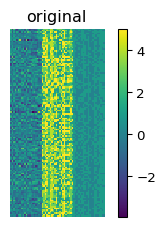

In [22]:
# Plot data
pplot([A], ["original"])

In [27]:
# Generate missing data
ratio = 0.1
np.random.seed(1)
A_masked, mask_indices, _ = mask(A, ratio)

In [83]:
# Process LRGC data format for GLRM
A_glrm, mask_indices_glrm = split_data(A, ns, mask_indices)
A_glrm[2][A_glrm[2] == 0] = -1 # Convert all 0s to -1 for boolean

In [84]:
# Impute missing data using LRGC

LREM = LowRankExpectationMaximization()
A_imp_lrgc, W_imp, sigma_imp = LREM.impute_missing(A_masked, k, verbose=True)

sigma estimate: 0.15161986508306882
log likelihood: 5171.919195661774
Updated error: 0.05007083974062923
sigma estimate: 0.12242321598102328
log likelihood: 6049.249514890779
Updated error: 0.024265874026041415
sigma estimate: 0.10981322033528285
log likelihood: 6429.841291845339
Updated error: 0.01590886773506502
sigma estimate: 0.10400246971649722
log likelihood: 6617.341187627665
Updated error: 0.011740628437844508
sigma estimate: 0.10111488813675454
log likelihood: 6714.087544563104
Updated error: 0.009246497043985778
early stop because changed likelihood below 1%


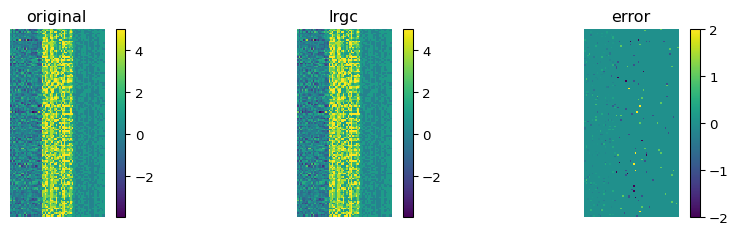

In [85]:
pplot([A, A_imp_lrgc, A - A_imp_lrgc], ["original", "lrgc", "error"])

In [74]:
# Calculate imputation errors from LRGC

NRMSE = NormalisedRMSErr()
ORDE = OrdErr()
BOOLE = ClassErr()

real_err_lrgc = NRMSE(A[:, :n1], A_imp_lrgc[:, :n1], mask_indices_glrm[0])
ord_err_lrgc = ORDE(A[:, n1:n1+n2], A_imp_lrgc[:, n1:n1+n2], mask_indices_glrm[1])
bool_err_lrgc = BOOLE(A[:, n1+n2:], A_imp_lrgc[:, n1+n2:], mask_indices_glrm[2])

print('LRGC errors: {}, {}, {}'.format(real_err_lrgc, ord_err_lrgc, bool_err_lrgc))

LRGC errors: 0.3263980732143942, 0.36065573770491804, 0.11206896551724138


In [92]:
# Impute missing data using pyglrm
cs_ns = np.insert(np.cumsum(ns), 0,0)
glrm_loss = [pyglrm.QuadLoss()]*ns[0] + [pyglrm.HingeLoss()]*ns[1] + [pyglrm.HingeLoss()]*ns[2]
regX, regY = pyglrm.ZeroReg(), [pyglrm.ZeroReg()]*sum(ns)
#glrm_loss = pyglrm.QuadLoss()
#regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
model = pyglrm.glrm(glrm_loss, regX, regY, n_components=5, offset=True, scale=True)
A_imp = model.fit_impute(A_masked)
to_datatype(A_imp, cs_ns)

array([[-2.50854615e+07, -4.48366264e+08, -9.09739207e+08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.08552447e+07, -8.21272060e+08, -1.67233748e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.58938302e+07, -6.30254914e+08, -1.27522142e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.23918729e+07, -5.39210063e+08, -1.09515394e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.07738121e+07, -6.85232315e+08, -1.39970766e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.74489069e+07, -6.20745138e+08, -1.25460464e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

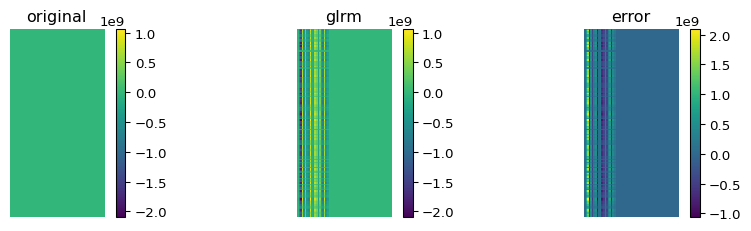

In [93]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

In [63]:
A_new = to_datatype(A_imp, cs_ns)

In [86]:
# Impute missing data using GLRM

glrm_rank = 5
loss = [QuadraticLoss, OrdinalLoss, HingeLoss]
regX, regY = QuadraticReg(0), QuadraticReg(0)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10) # optional (default TOL = 1e-3)
glrm_model = GLRM(A_glrm, loss, regX, regY, glrm_rank, mask_indices_glrm, converge = converge, obj_type = 1)
glrm_model.fit()
A_imp_glrm = glrm_model.predict()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/GLRM-0.0.1-py3.8.egg/glrm/glrm.py:220: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplica

---------- ITERATION 0 ----------


/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Residual norm for X minimization: 2691.969637497477
Residual norm for Y minimization: 228.02682116986574
Residual norm for Y minimization: 589.9799150078268
Residual norm for Y minimization: 1001.2211540114125
---------- ITERATION 1 ----------
Residual norm for X minimization: 1726.309657397425
Residual norm for Y minimization: 243.93724606006398
Residual norm for Y minimization: 567.3322319721568
Residual norm for Y minimization: 861.1522984167251
---------- ITERATION 2 ----------
Residual norm for X minimization: 1666.2578270843076
Residual norm for Y minimization: 249.64891881569847
Residual norm for Y minimization: 569.3069185478822
Residual norm for Y minimization: 820.3561816960326
---------- ITERATION 3 ----------
Residual norm for X minimization: 1644.4605015878274
Residual norm for Y minimization: 249.26390802149407
Residual norm for Y minimization: 570.9260359647102
Residual norm for Y minimization: 799.6334864091252
---------- ITERATION 4 ----------
Residual norm for X minim

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


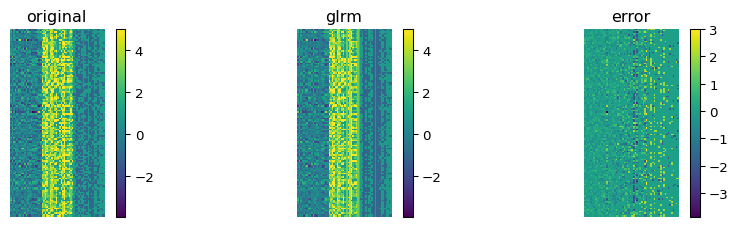

In [87]:
pplot([np.hstack(A_glrm), A_imp_glrm, np.hstack(A_glrm) - A_imp_glrm], ["original", "glrm", "error"])

In [97]:
# Calculate imputation errors from GLRM
NRMSE = NormalisedRMSErr()
ORDE = OrdErr()
BOOLE = ClassErr()
real_err_glrm = NRMSE(A_glrm[0], A_imp_glrm[:, :n1], mask_indices_glrm[0])
ord_err_glrm = ORDE(A_glrm[1], A_imp_glrm[:, n1:n1+n2], mask_indices_glrm[1])
bool_err_glrm = BOOLE(A_glrm[2], A_imp_glrm[:, n1+n2:], mask_indices_glrm[2])

print('LRGC errors: {}, {}, {}'.format(real_err_glrm, ord_err_glrm, bool_err_glrm))

LRGC errors: 0.41096494843427667, 0.5819672131147541, 0.1853448275862069


## Experiment 1

In [109]:
ratio = 0.1
data_type = 'lrgc'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_1_0.1_lrgc_lrgc'

In [110]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

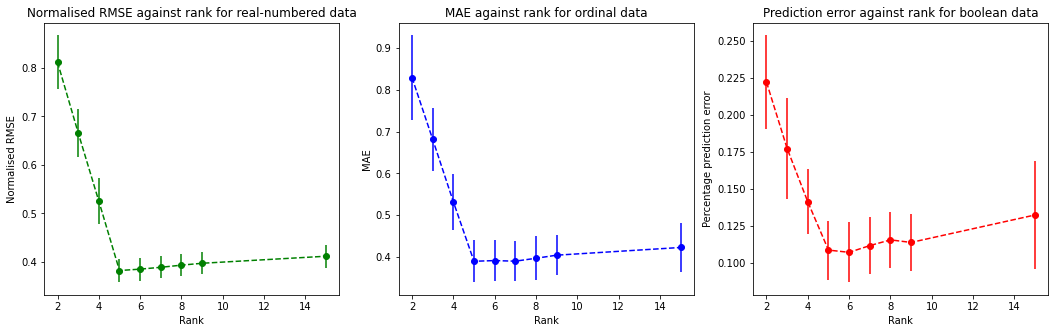

In [16]:
# Load data from csv
df = pd.read_csv('imputation_exp_outputs/Exp_1_0.1_lrgc_lrgc.csv')
k_list = df['Rank']
mean_errs = [df[h] for h in list(df) if 'Mean' in h]
std_dev_errs = [df[h] for h in list(df) if 'Std' in h]

# Plot graphs
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Normalised RMSE against rank for real-numbered data')
ax1.set_xlabel('Rank')
ax1.set_ylabel('Normalised RMSE')
ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('MAE against rank for ordinal data')
ax2.set_xlabel('Rank')
ax2.set_ylabel('MAE')
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Prediction error against rank for boolean data')
ax3.set_xlabel('Rank')
ax3.set_ylabel('Percentage prediction error')
plt.savefig('imputation_exp_outputs/Exp_1_0.1_lrgc_lrgc.png')

## Experiment 2

In [5]:
ratio = 0.1
data_type = 'lrgc'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_2_0.1_lrgc_glrm'

In [10]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

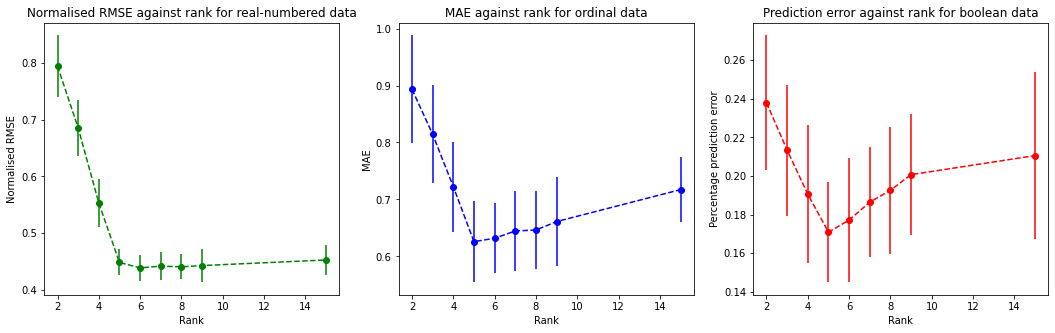

In [17]:
# Load data from csv
df = pd.read_csv('imputation_exp_outputs/Exp_2_0.1_lrgc_glrm.csv')
k_list = df['Rank']
mean_errs = [df[h] for h in list(df) if 'Mean' in h]
std_dev_errs = [df[h] for h in list(df) if 'Std' in h]

# Plot graphs
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Normalised RMSE against rank for real-numbered data')
ax1.set_xlabel('Rank')
ax1.set_ylabel('Normalised RMSE')
ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('MAE against rank for ordinal data')
ax2.set_xlabel('Rank')
ax2.set_ylabel('MAE')
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Prediction error against rank for boolean data')
ax3.set_xlabel('Rank')
ax3.set_ylabel('Percentage prediction error')
plt.savefig('imputation_exp_outputs/Exp_2_0.1_lrgc_glrm.png')

## Experiment 3

In [13]:
ratio = 0.4
data_type = 'lrgc'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_3_0.4_lrgc_lrgc'

In [14]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

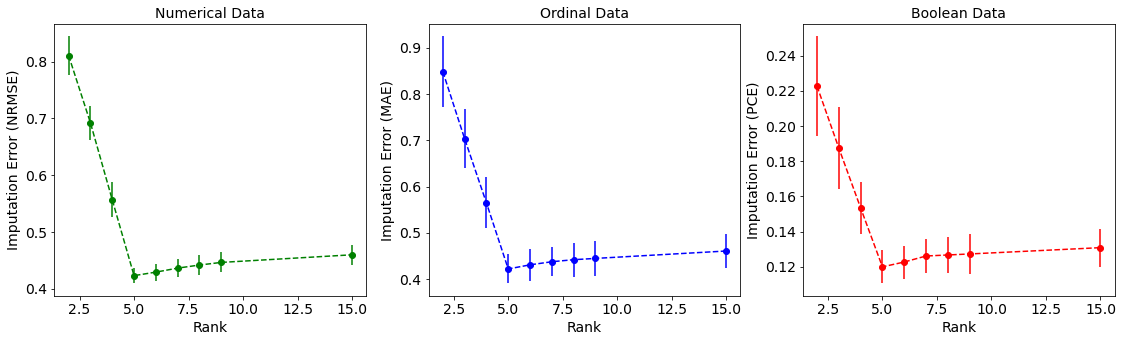

In [4]:
# Load data from csv
df = pd.read_csv('imputation_exp_outputs/Exp_3_0.4_lrgc_lrgc.csv')
k_list = df['Rank']
mean_errs = [df[h] for h in list(df) if 'Mean' in h]
std_dev_errs = [df[h] for h in list(df) if 'Std' in h]

# Plot graphs
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Numerical Data', fontsize=14)
ax1.set_xlabel('Rank', fontsize=14)
ax1.set_ylabel('Imputation Error (NRMSE)', fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.errorbar(k_list, mean_errs[1],  yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('Ordinal Data', fontsize=14)
ax2.set_xlabel('Rank', fontsize=14)
ax2.set_ylabel('Imputation Error (MAE)', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Boolean Data', fontsize=14)
ax3.set_xlabel('Rank', fontsize=14)
ax3.set_ylabel('Imputation Error (PCE)', fontsize=14)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
#plt.show()
plt.savefig('imputation_exp_outputs/Exp_3_0.4_lrgc_lrgc.pdf')

## Experiment 4

In [6]:
ratio = 0.4
data_type = 'lrgc'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_4_0.4_lrgc_glrm'

In [20]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

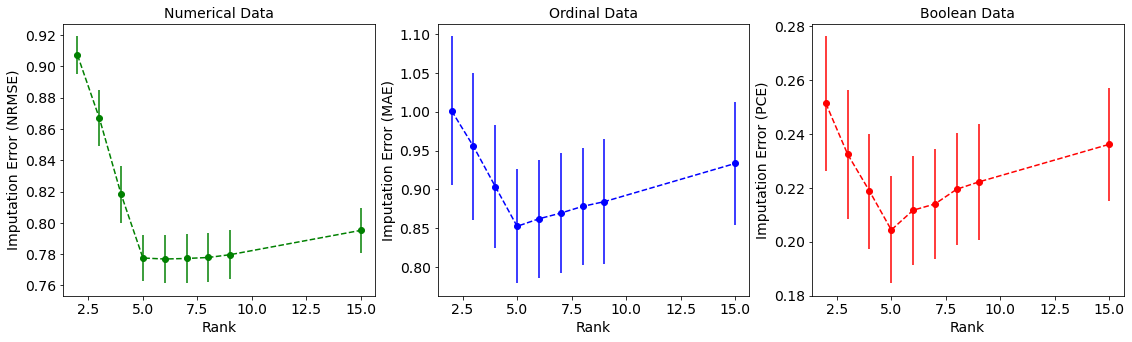

In [9]:
# Load data from csv
df = pd.read_csv('imputation_exp_outputs/' + exp_name + '.csv')
k_list = df['Rank']
mean_errs = [df[h] for h in list(df) if 'Mean' in h]
std_dev_errs = [df[h] for h in list(df) if 'Std' in h]

# Plot graphs
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.errorbar(k_list, mean_errs[0], yerr=std_dev_errs[0], fmt='go--')
ax1.set_title('Numerical Data', fontsize=14)
ax1.set_xlabel('Rank', fontsize=14)
ax1.set_ylabel('Imputation Error (NRMSE)', fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.errorbar(k_list, mean_errs[1], yerr=std_dev_errs[1], fmt='bo--')
ax2.set_title('Ordinal Data', fontsize=14)
ax2.set_xlabel('Rank', fontsize=14)
ax2.set_ylabel('Imputation Error (MAE)', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax3.errorbar(k_list, mean_errs[2], yerr=std_dev_errs[2], fmt='ro--')
ax3.set_title('Boolean Data', fontsize=14)
ax3.set_xlabel('Rank', fontsize=14)
ax3.set_ylabel('Imputation Error (PCE)', fontsize=14)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
#plt.show()
plt.savefig('imputation_exp_outputs/' + exp_name + '.pdf')

## Experiment 5

In [22]:
ratio = 0.02
data_type = 'lrgc'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_5_0.02_lrgc_lrgc'

In [23]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

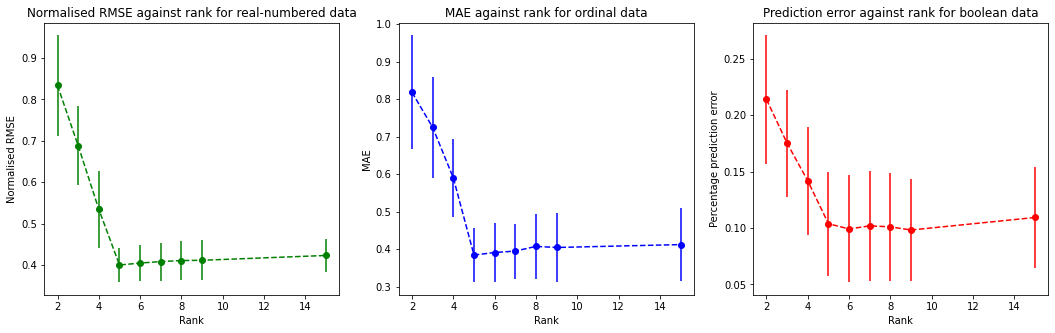

In [26]:
plotting_1(exp_name)

## Experiment 6

In [27]:
ratio = 0.02
data_type = 'lrgc'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_6_0.02_lrgc_glrm'

In [28]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


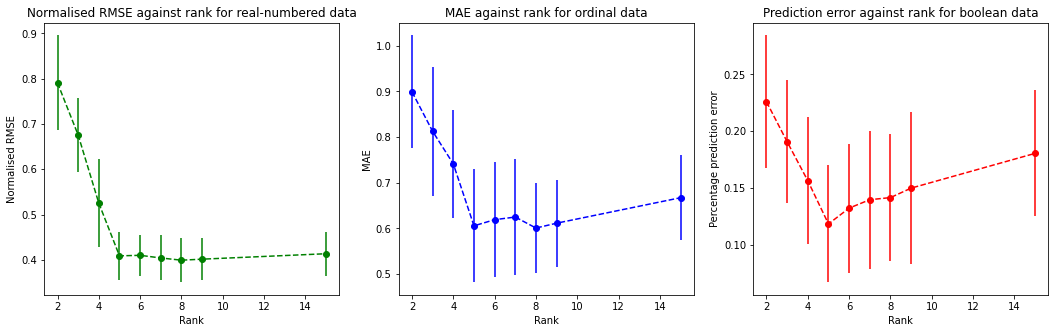

In [29]:
plotting_1(exp_name)

## Experiment 7

In [33]:
ratio = 0.6
data_type = 'lrgc'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_7_0.6_lrgc_lrgc'

In [34]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 8

In [30]:
ratio = 0.6
data_type = 'lrgc'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_8_0.6_lrgc_glrm'

In [31]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


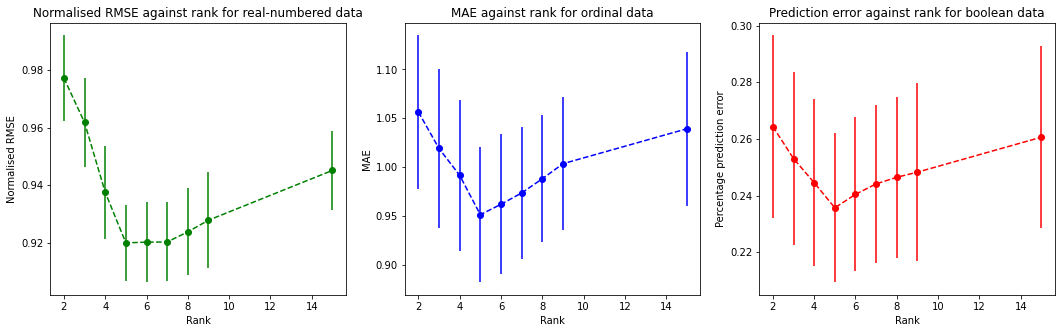

In [32]:
plotting_1(exp_name)

## Exp 27

In [10]:
data_type = 'lrgc'
model_type = 'pyglrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
#k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 2

In [9]:
ratio = 0.02
exp_name = 'Exp_27_0.02_lrgc_pyglrm'

In [11]:
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

([5],
 [[255173279.014917], [143589027.35174406], [1.0]],
 [[360785669.66732776], [202984225.50443834], [0.0]])

## Error against missing ratio - LRGC data

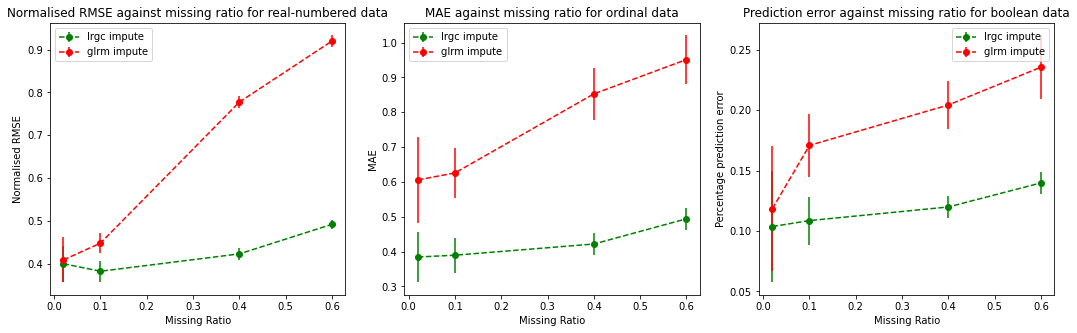

In [38]:
# Load lrgc model data from csv
lrgc_df = pd.read_csv('imputation_exp_outputs/vary_ratio_lrgc_lrgc.csv')
ratio_list = lrgc_df['Ratio']
lrgc_mean_errs = [lrgc_df[h] for h in list(lrgc_df) if 'Mean' in h]
lrgc_std_dev_errs = [lrgc_df[h] for h in list(lrgc_df) if 'Std' in h]

# Load glrm model data from csv
glrm_df = pd.read_csv('imputation_exp_outputs/vary_ratio_lrgc_glrm.csv')
glrm_mean_errs = [glrm_df[h] for h in list(glrm_df) if 'Mean' in h]
glrm_std_dev_errs = [glrm_df[h] for h in list(glrm_df) if 'Std' in h]

# Plot graphs
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.errorbar(ratio_list, lrgc_mean_errs[0], yerr=lrgc_std_dev_errs[0], fmt='go--', label='lrgc impute')
ax1.errorbar(ratio_list, glrm_mean_errs[0], yerr=glrm_std_dev_errs[0], fmt='ro--', label='glrm impute')
ax1.set_title('Normalised RMSE against missing ratio for real-numbered data')
ax1.set_xlabel('Missing Ratio')
ax1.set_ylabel('Normalised RMSE')
ax1.legend()
ax2.errorbar(ratio_list, lrgc_mean_errs[1], yerr=lrgc_std_dev_errs[1], fmt='go--', label='lrgc impute')
ax2.errorbar(ratio_list, glrm_mean_errs[1], yerr=glrm_std_dev_errs[1], fmt='ro--', label='glrm impute')
ax2.set_title('MAE against missing ratio for ordinal data')
ax2.set_xlabel('Missing Ratio')
ax2.set_ylabel('MAE')
ax2.legend()
ax3.errorbar(ratio_list, lrgc_mean_errs[2], yerr=lrgc_std_dev_errs[2], fmt='go--', label='lrgc impute')
ax3.errorbar(ratio_list, glrm_mean_errs[2], yerr=glrm_std_dev_errs[2], fmt='ro--', label='glrm impute')
ax3.set_title('Prediction error against missing ratio for boolean data')
ax3.set_xlabel('Missing Ratio')
ax3.set_ylabel('Percentage prediction error')
ax3.legend()
plt.savefig('imputation_exp_outputs/vary_ratio_lrgc_lrgc.png')

## Experiment 9

In [52]:
ratio = 0.02
data_type = 'syn_uni'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [2, 3, 4, 5, 6, 7, 8, 9, 15]
iterations = 20
exp_name = 'Exp_9_0.02_syn_uni_lrgc'

In [53]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 10
Try with unskewed ordinal data

In [15]:
A, A_masked, mask_indices = generate_data('lrgc_equalcut', 120, [20,20,20], 5, 0.1, 2, 0.1)

In [17]:
ratio = 0.1
data_type = 'lrgc_equalcut'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_10_0.1_lrgc_equalcut_lrgc'

In [18]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 11

In [19]:
ratio = 0.1
data_type = 'lrgc_equalcut'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_11_0.1_lrgc_equalcut_glrm'

In [20]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 12

In [21]:
ratio = 0.02
data_type = 'lrgc_equalcut'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_12_0.02_lrgc_equalcut_lrgc'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 13

In [23]:
ratio = 0.02
data_type = 'lrgc_equalcut'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_13_0.02_lrgc_equalcut_glrm'

In [24]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

# Experiment 14

In [25]:
ratio = 0.4
data_type = 'lrgc_equalcut'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_14_0.4_lrgc_equalcut_lrgc'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 15

In [27]:
ratio = 0.4
data_type = 'lrgc_equalcut'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_15_0.4_lrgc_equalcut_glrm'

In [28]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 16

In [29]:
ratio = 0.6
data_type = 'lrgc_equalcut'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_16_0.6_lrgc_equalcut_lrgc'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Experiment 17

In [31]:
ratio = 0.6
data_type = 'lrgc_equalcut'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_17_0.6_lrgc_equalcut_glrm'

In [32]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma)

## Error against missing ratio - LRGC equalcut data

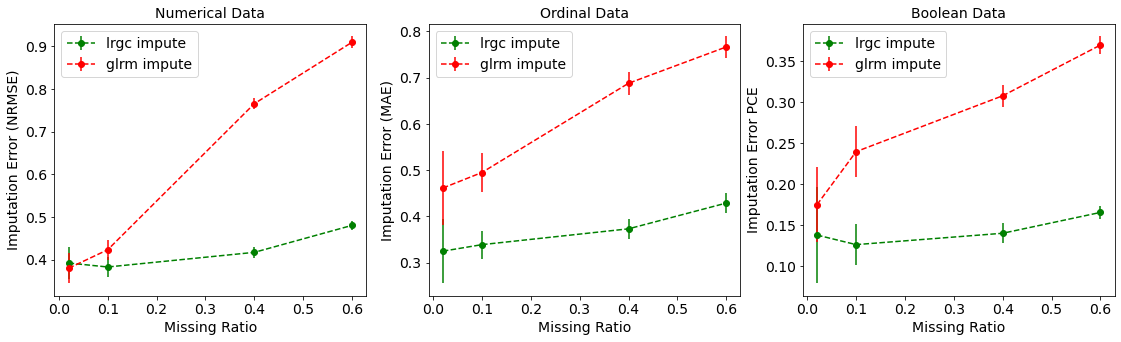

In [13]:
# Load lrgc model data from csv
lrgc_df = pd.read_csv('imputation_exp_outputs/vary_ratio_lrgc_equalcut_lrgc.csv')
ratio_list = lrgc_df['Ratio']
lrgc_mean_errs = [lrgc_df[h] for h in list(lrgc_df) if 'Mean' in h]
lrgc_std_dev_errs = [lrgc_df[h] for h in list(lrgc_df) if 'Std' in h]

# Load glrm model data from csv
glrm_df = pd.read_csv('imputation_exp_outputs/vary_ratio_lrgc_equalcut_glrm.csv')
glrm_mean_errs = [glrm_df[h] for h in list(glrm_df) if 'Mean' in h]
glrm_std_dev_errs = [glrm_df[h] for h in list(glrm_df) if 'Std' in h]

# Plot graphs
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.errorbar(ratio_list, lrgc_mean_errs[0], yerr=lrgc_std_dev_errs[0], fmt='go--', label='lrgc impute')
ax1.errorbar(ratio_list, glrm_mean_errs[0], yerr=glrm_std_dev_errs[0], fmt='ro--', label='glrm impute')
ax1.set_title('Numerical Data', fontsize=14)
ax1.set_xlabel('Missing Ratio', fontsize=14)
ax1.set_ylabel('Imputation Error (NRMSE)', fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.legend(fontsize=14)
ax2.errorbar(ratio_list, lrgc_mean_errs[1], yerr=lrgc_std_dev_errs[1], fmt='go--', label='lrgc impute')
ax2.errorbar(ratio_list, glrm_mean_errs[1], yerr=glrm_std_dev_errs[1], fmt='ro--', label='glrm impute')
ax2.set_title('Ordinal Data', fontsize=14)
ax2.set_xlabel('Missing Ratio', fontsize=14)
ax2.set_ylabel('Imputation Error (MAE)', fontsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(fontsize=14)
ax3.errorbar(ratio_list, lrgc_mean_errs[2], yerr=lrgc_std_dev_errs[2], fmt='go--', label='lrgc impute')
ax3.errorbar(ratio_list, glrm_mean_errs[2], yerr=glrm_std_dev_errs[2], fmt='ro--', label='glrm impute')
ax3.set_title('Boolean Data', fontsize=14)
ax3.set_xlabel('Missing Ratio', fontsize=14)
ax3.set_ylabel('Imputation Error PCE', fontsize=14)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.legend(fontsize=14)
#plt.show()
plt.savefig('imputation_exp_outputs/vary_ratio_lrgc_equalcut_lrgc.pdf')

# Real Data

In [14]:
# Process 
hye_df = pd.read_csv('datasets/haveyouever.csv')
hye_df = hye_df.dropna()
hye_A = hye_df.iloc[:, 1:].to_numpy()
hye_A = (hye_A == 1).astype(float)
print(hye_A.shape)

(3225, 30)


In [120]:
ratio = 0.02
A_masked, mask_indices, _ = mask(hye_A, ratio)
LREM = LowRankExpectationMaximization()
A_imp_lrgc, W_imp, sigma_imp = LREM.impute_missing(A_masked, 5, verbose=True)

sigma estimate: 0.6137776331830774
log likelihood: -1825.2507812040953
Updated error: 0.14490684158899977
sigma estimate: 0.679901169920693
log likelihood: -5191.947944912485
Updated error: 0.0783027683154973
sigma estimate: 0.7079369069476867
log likelihood: -7257.403621039206
Updated error: 0.0560560654718896
sigma estimate: 0.7275958189997049
log likelihood: -8629.045762586211
Updated error: 0.04599841555084992
sigma estimate: 0.7433267217833246
log likelihood: -9639.905273839466
Updated error: 0.03918134448203656
sigma estimate: 0.7560758857384643
log likelihood: -10430.015061999029
Updated error: 0.03357504154728916
sigma estimate: 0.7663092052848728
log likelihood: -11048.876339898938
Updated error: 0.028748097241083837
sigma estimate: 0.7744359686304964
log likelihood: -11530.625260866655
Updated error: 0.024611060505901835
sigma estimate: 0.7808362709344818
log likelihood: -11903.087446767317
Updated error: 0.021119060684183674
sigma estimate: 0.7858460146588906
log likelihood:

In [122]:
err = ClassErr()
print(err(hye_A, A_imp_lrgc, indices=mask_indices))

0.23875968992248062


## Experiment 18

In [2]:
ratio = 0.02
data_type = 'real_world'
model_type = 'lrgc'
m = hye_A.shape[0]
ns = [hye_A.shape[1]]
k = None
k_exp_list = [1,2,3,4]
iterations = 5
exp_name = 'Exp_18_0.02_hye_lrgc'
rw_data = hye_A
one_dt = 'bool'

NameError: name 'hye_A' is not defined

In [140]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, rw_data=rw_data, one_dt=one_dt, mode='a')

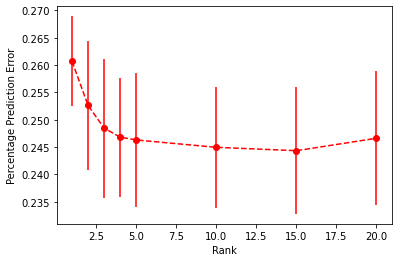

In [10]:
plotting_bool('Exp_18_0.02_hye_lrgc')

## Experiment 19

In [7]:
ratio = 0.02
data_type = 'real_world'
model_type = 'glrm'
m = hye_A.shape[0]
ns = [hye_A.shape[1]]
k = None
k_exp_list = [10]
iterations = 5
exp_name = 'Exp_19_0.02_hye_glrm'
rw_data = hye_A
one_dt = 'bool'

In [ ]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, rw_data=rw_data, one_dt=one_dt, mode='a')

## Experiment 22

In [17]:
ratio = 0.6
data_type = 'real_world'
model_type = 'lrgc'
m = hye_A.shape[0]
ns = [hye_A.shape[1]]
k = None
k_exp_list = [5, 10, 15, 20]
iterations = 5
exp_name = 'Exp_22_0.6_hye_lrgc'
rw_data = hye_A
one_dt = 'bool'

In [18]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, rw_data=rw_data, one_dt=one_dt, mode='a')

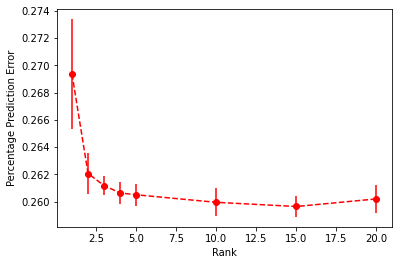

In [19]:
plotting_bool(exp_name)

## Experiment 23

In [23]:
ratio = 0.02
data_type = 'syn_uninoise'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_23_0.02_syn_uninoise_lrgc'

In [30]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma=sigma)

## Experiment 24

In [31]:
ratio = 0.02
data_type = 'syn_uninoise'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.1
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_24_0.02_syn_uninoise_glrm'

In [32]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma=sigma)

## Experiment 25

In [33]:
ratio = 0.02
data_type = 'syn_uninoise'
model_type = 'lrgc'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.4
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_25_0.02_syn_uninoise_lrgc_sigma0.4'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma=sigma)

## Experiment 26

In [35]:
ratio = 0.02
data_type = 'syn_uninoise'
model_type = 'glrm'
m = 120
ns = [20, 20, 20]
k = 5
sigma = 0.4
k_exp_list = [5]
iterations = 20
exp_name = 'Exp_26_0.02_syn_uninoise_glrm_sigma0.4'

In [36]:
%%capture
imputation_exp_1(ratio, data_type, model_type, m, ns, k, k_exp_list, iterations, exp_name, sigma=sigma)